# Quanvolutional Neural Network for digit prediction from the MNIST Image dataset

### Quantum convolution

One can extend the same idea also to the context of quantum variational circuits. A possible approach is given by the following procedure which is very similar to the one used in [Ref](https://arxiv.org/abs/1904.04767). The scheme is also represented in the figure at the top of this tutorial.

* A small region of the input image, in our example a $2\times2$ square, is embedded into a quantum circuit. In this demo, this is achieved with parametrized rotations applied to the qubits initialized in the ground state.

* A quantum computation, associated to a unitary `U`, is performed on the system. The unitary could be generated by a variational quantum circuit or, more simply, by a random circuit as proposed in [Ref](https://arxiv.org/abs/1904.04767).

* The quantum system is finally measured, obtaining a list of classical expectation values. The measurement results could also be classically post-processed as proposed in [Ref](https://arxiv.org/abs/1904.04767) but, for simplicity, in this demo we directly use the raw expectation values.

* Analogously to a classical convolution layer, each expectation value is mapped to a different channel of a single output pixel.

* Iterating the same procedure over different regions, one can scan the full input image, producing an output object which will be structured as a multi-channel image.

* The quantum convolution can be followed by further quantum layers or by classical layers.

* The main difference with respect to a classical convolution is that a quantum circuit can generate highly complex kernels whose computation could be, at least in principle, classically intractable.

## Imports

In [1]:
import pennylane as qml
import pennylane.numpy as np
from pennylane.templates import RandomLayers
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras

2024-08-07 05:17:18.152309: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 05:17:18.248383: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-07 05:17:19.926045: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Setting of the main hyper-parameters of the model

In [3]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "../_static/demonstration_assets/quanvolution/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

### Loading of the MNIST dataset

In [4]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

In [5]:
# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

### Quantum circuit as a convolution kernel

In [6]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

#### Quanvolutional function

In [7]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

### Quantum pre-processing of the dataset

In [8]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save("/home/ronit/Desktop/Womanium AI+Quantum project/QML-for-Conspicuity-Detection-in-Production/Task-3/" + "q_train_images.npy", q_train_images)
    np.save("/home/ronit/Desktop/Womanium AI+Quantum project/QML-for-Conspicuity-Detection-in-Production/Task-3/" + "q_test_images.npy", q_test_images)

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


In [9]:
# Load pre-processed images
q_train_images = np.load("/home/ronit/Desktop/Womanium AI+Quantum project/QML-for-Conspicuity-Detection-in-Production/Task-3/" + "q_train_images.npy")
q_test_images = np.load("/home/ronit/Desktop/Womanium AI+Quantum project/QML-for-Conspicuity-Detection-in-Production/Task-3/" + "q_test_images.npy")

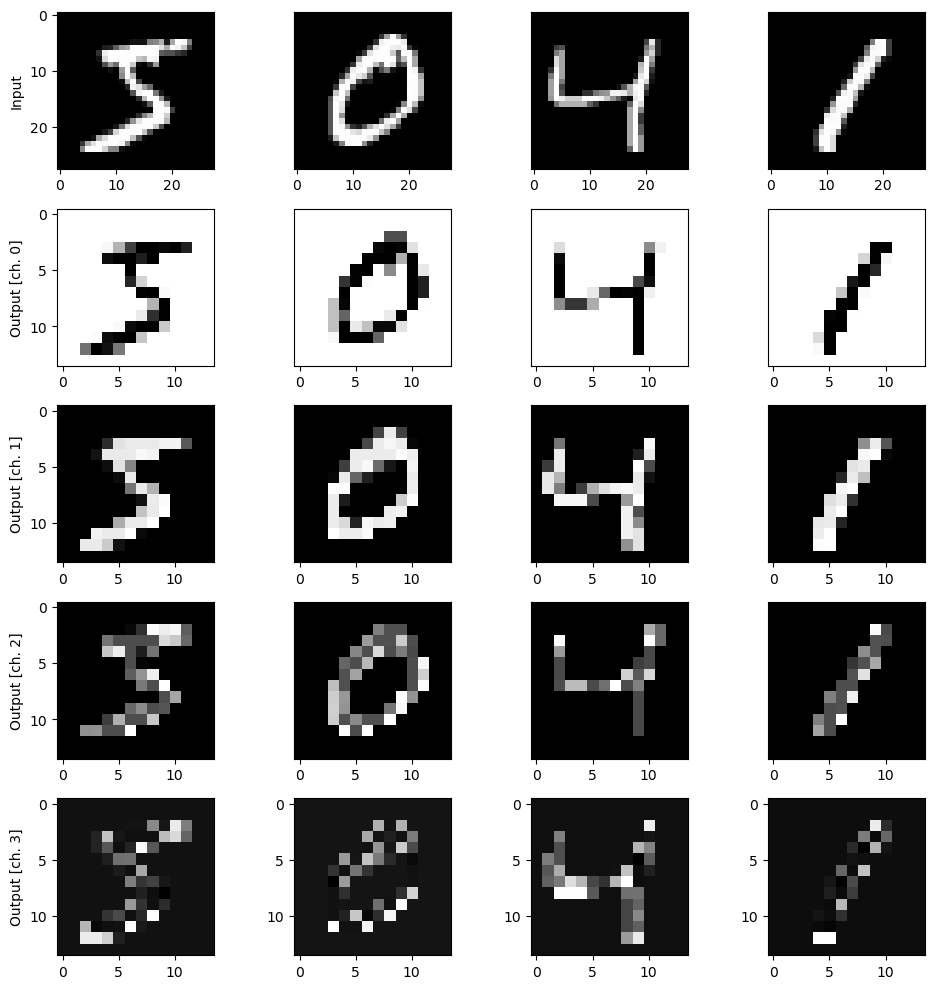

In [10]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

## plotting
plt.tight_layout()
plt.show()

### Hybrid quantum-classical model

In [11]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

### Training

In [12]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

2024-08-07 05:23:52.604467: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/30
13/13 - 1s - 97ms/step - accuracy: 0.1400 - loss: 2.5183 - val_accuracy: 0.3000 - val_loss: 2.2592
Epoch 2/30
13/13 - 0s - 8ms/step - accuracy: 0.4000 - loss: 1.8637 - val_accuracy: 0.4000 - val_loss: 2.0344
Epoch 3/30
13/13 - 0s - 7ms/step - accuracy: 0.6000 - loss: 1.5289 - val_accuracy: 0.4000 - val_loss: 1.9007
Epoch 4/30
13/13 - 0s - 7ms/step - accuracy: 0.7800 - loss: 1.2455 - val_accuracy: 0.4333 - val_loss: 1.7571
Epoch 5/30
13/13 - 0s - 7ms/step - accuracy: 0.8400 - loss: 1.0366 - val_accuracy: 0.5000 - val_loss: 1.6410
Epoch 6/30
13/13 - 0s - 8ms/step - accuracy: 0.9000 - loss: 0.8631 - val_accuracy: 0.5333 - val_loss: 1.5582
Epoch 7/30
13/13 - 0s - 7ms/step - accuracy: 0.9200 - loss: 0.7283 - val_accuracy: 0.5667 - val_loss: 1.4870
Epoch 8/30
13/13 - 0s - 7ms/step - accuracy: 0.9200 - loss: 0.6204 - val_accuracy: 0.6333 - val_loss: 1.4249
Epoch 9/30
13/13 - 0s - 8ms/step - accuracy: 0.9200 - loss: 0.5324 - val_accuracy: 0.6333 - val_loss: 1.3744
Epoch 10/30
13/13 

In [13]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 76ms/step - accuracy: 0.1200 - loss: 2.3265 - val_accuracy: 0.2000 - val_loss: 2.1395
Epoch 2/30
13/13 - 0s - 8ms/step - accuracy: 0.3600 - loss: 1.9212 - val_accuracy: 0.2333 - val_loss: 2.0021
Epoch 3/30
13/13 - 0s - 8ms/step - accuracy: 0.6600 - loss: 1.6372 - val_accuracy: 0.4000 - val_loss: 1.8662
Epoch 4/30
13/13 - 0s - 9ms/step - accuracy: 0.8400 - loss: 1.4013 - val_accuracy: 0.5333 - val_loss: 1.7376
Epoch 5/30
13/13 - 0s - 8ms/step - accuracy: 0.8600 - loss: 1.2045 - val_accuracy: 0.5667 - val_loss: 1.6249
Epoch 6/30
13/13 - 0s - 8ms/step - accuracy: 0.8800 - loss: 1.0418 - val_accuracy: 0.5667 - val_loss: 1.5311
Epoch 7/30
13/13 - 0s - 9ms/step - accuracy: 0.9400 - loss: 0.9073 - val_accuracy: 0.5667 - val_loss: 1.4541
Epoch 8/30
13/13 - 0s - 9ms/step - accuracy: 0.9600 - loss: 0.7958 - val_accuracy: 0.6333 - val_loss: 1.3908
Epoch 9/30
13/13 - 0s - 8ms/step - accuracy: 0.9600 - loss: 0.7027 - val_accuracy: 0.6667 - val_loss: 1.3381
Epoch 10/30
13/13 

## Results

/tmp/ipykernel_68237/925943430.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


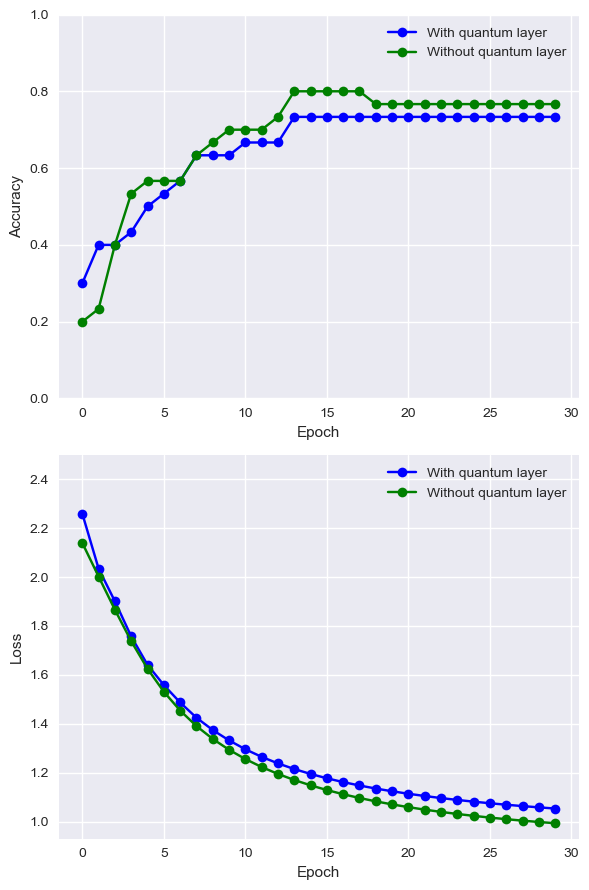

In [14]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()